In [51]:
# 基础库导入




import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [52]:
from abupy import AbuDoubleMaBuy, AbuDoubleMaSell, AbuSDBreak, AbuFactorBuyBreak
from abupy import AbuFactorCloseAtrNStop, AbuFactorAtrNStop, AbuFactorPreAtrNStop
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType
from abupy import AbuFactorSellNDay, AbuFactorBuyWD, AbuFactorSellBreak

到目前为止已经示例了很多买入因子，abupy中一个特点即是可以在交易中使用多个买入，卖出因子并行执行生效。

在回测交易中可以组织多个买入因子构建序列，如：

1. 自适应动态双均线买入金叉策略
2. 海龟42天周期向上突破买入策略
3. 大盘拟合稳定21天突破买入策略

亦可以组织多个卖出策略构建序列，如：

1. 双均线卖出死叉策略
2. 海龟21天周期向下突破卖出策略
3. 基本止盈止损策略：止损1.0，止盈3.0
4. 风险控制止损策略：参数1.5
5. 利润保护止盈策略：参数1.5

下面代码按照上述进行买入，卖出因子序列构建，如下：

In [53]:
buy_factors = [{'class': AbuDoubleMaBuy},
               {'xd': 42, 'class': AbuFactorBuyBreak}, 
               {'xd': 21, 'class': AbuSDBreak}]

sell_factors = [
    {'class': AbuDoubleMaSell},
    {'xd': 21, 'class': AbuFactorSellBreak},
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0, 'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

构建完策略后，下面使用沙盒数据美股数据，示例并行执行上述策略进行回测，如下：

买入后卖出的交易数量:131
买入后尚未卖出的交易数量:7
胜率:51.9084%
平均获利期望:15.9512%
平均亏损期望:-5.8270%
盈亏比:2.7959
策略收益: 45.0467%
基准收益: 15.0841%
策略年化收益: 22.5234%
基准年化收益: 7.5420%
策略买入成交比例:67.3913%
策略资金利用率比例:37.0038%
策略共执行504个交易日


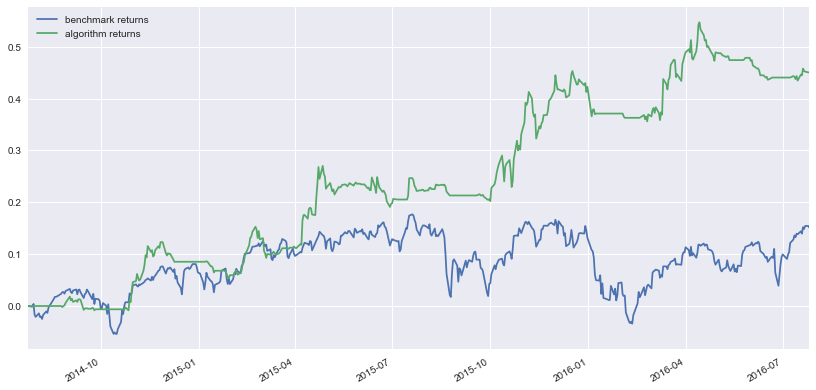

In [54]:
# 使用沙盒内的美股做为回测目标
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 
                     'usGOOG', 'usWUBA', 'usVIPS']

# 初始资金量
cash = 3000000
def run_loo_back(choice_symbols, ps=None, n_folds=2, start=None, end=None, only_info=False):
    """封装一个回测函数，返回回测结果，以及回测度量对象"""
    if choice_symbols[0].startswith('us'):
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
    else:
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
    abu_result_tuple, _ = abu.run_loop_back(cash,
                                           buy_factors,
                                           sell_factors,
                                           ps,
                                           start=start,
                                           end=end,
                                           n_folds=n_folds,
                                           choice_symbols=choice_symbols)
    """
        这里把所有因子的唯一名称只取类名称，不要参数了:
        eg：AbuDoubleMaBuy:fast=5,slow=60->AbuDoubleMaBuy
    """
    abu_result_tuple.orders_pd['buy_factor'] = abu_result_tuple.orders_pd[
        'buy_factor'].apply(lambda bf: bf.split(':')[0])
    ABuProgress.clear_output()
    metrics = AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=only_info, 
                                only_info=only_info,
                                only_show_returns=True)
    return abu_result_tuple, metrics

abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

下面可视化各个买入因子的生效数量以及比例，如下：

买入择时生效因子分布：
AbuDoubleMaBuy       33
AbuFactorBuyBreak    38
AbuSDBreak           60
dtype: int64


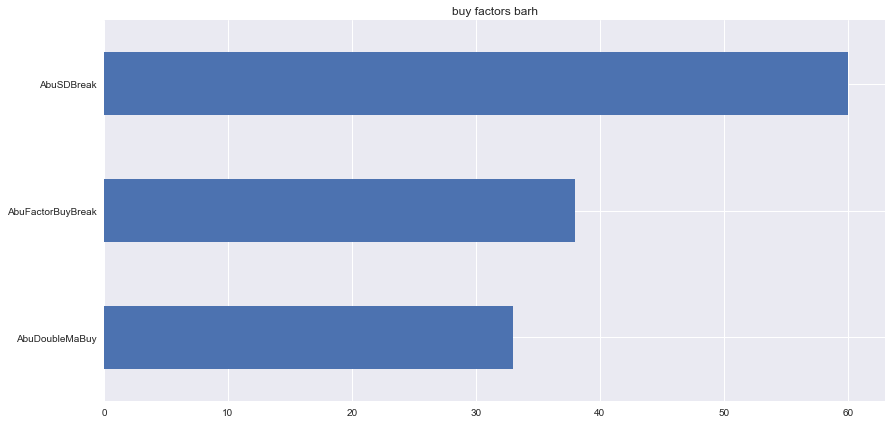

In [55]:
metrics.plot_buy_factors()

下面可视化各个卖出因子的生效数量比例，可以发现双均线卖出死叉策略(AbuDoubleMaSell)和海龟21天周期向下突破卖出策略(AbuFactorSellBreak)生效的比例和数量都很多：

卖出择时生效因子分布：
AbuDoubleMaSell:61                        14
AbuFactorAtrNStop:stop_loss=1.0            6
AbuFactorAtrNStop:stop_win=3.0            18
AbuFactorCloseAtrNStop:close_atr_n=1.5    47
AbuFactorPreAtrNStop:pre_atr=1.5          14
AbuFactorSellBreak:21                     32
dtype: int64


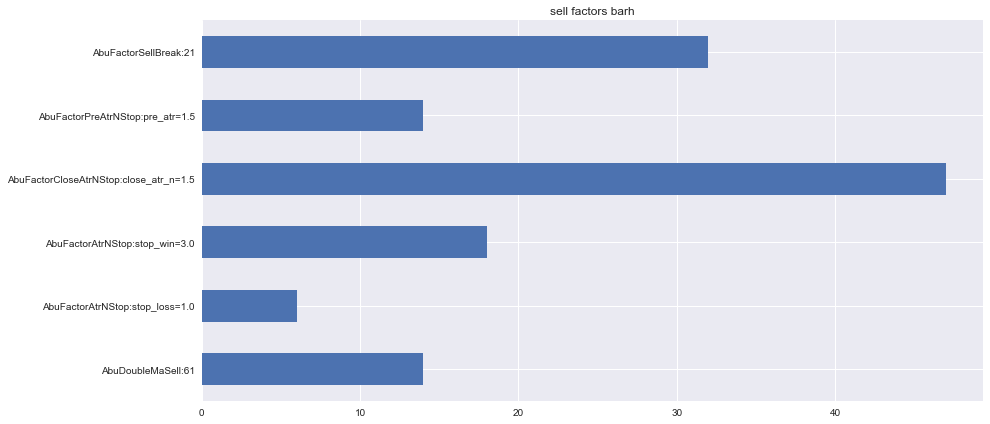

In [56]:
metrics.plot_sell_factors()

虽然上面的回测没有出错，但是本示例中多因子策略的设计组织本来是想要如下效果的：

![](./image/mmm.png)

即理想的多因子策略组织为：

1. 基础卖出因子（止盈止损&风险控制&利润保护）对应所有买入因子生效
2. 海龟21天周期向下卖出只对应海龟42天周期向上买入生效
3. 双均线卖出死叉只对应买入动态双均线金叉生效

这个问题在有些特殊的卖出因子组合下还会导致整体策略组合配合出错，如下

1. 买入因子组合中添加在‘第26节 星期几是这个股票的好日子’中示例的周期短线均值回复买入策略AbuFactorBuyWD
2. 卖出因子组合中添加AbuFactorSellNDay，sell_n=1配合AbuFactorBuyWD短线买入策略持有一天就卖出股票

添加后进行回测，代码如下所示：

买入后卖出的交易数量:232
买入后尚未卖出的交易数量:2
胜率:20.6897%
平均获利期望:1.5342%
平均亏损期望:-1.8610%
盈亏比:0.8385
策略收益: -3.8801%
基准收益: 15.0841%
策略年化收益: -1.9400%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:2.8394%
策略共执行504个交易日


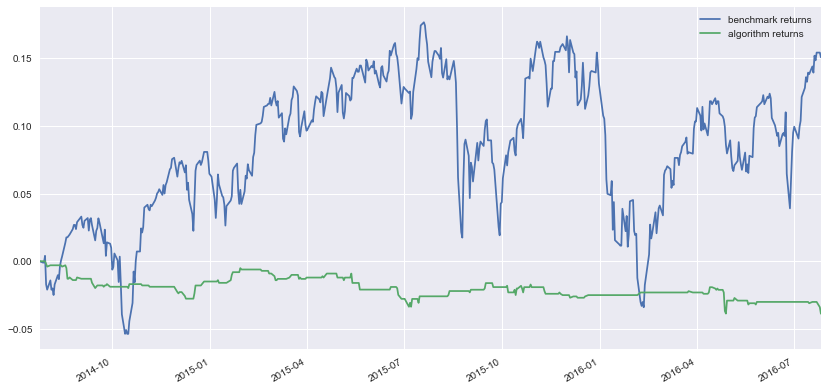

In [57]:
# 添加AbuFactorBuyWD
buy_factors = [
               {'class': AbuFactorBuyWD},
               {'class': AbuDoubleMaBuy},
               {'xd': 42, 'class': AbuFactorBuyBreak}, 
               {'xd': 21, 'class': AbuSDBreak}]
# 添加AbuFactorSellNDay
sell_factors = [
    {'class': AbuFactorSellNDay, 'sell_n': 1, 'is_sell_today': True},
    {'class': AbuDoubleMaSell},
    {'xd': 21, 'class': AbuFactorSellBreak},
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0, 'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

由上回测结果可以看到效果很差，统计交易单中个买入因子所对应的卖出因子，可以发现卖出因子全部都使用了AbuFactorSellNDay，即所有的交易都只持有了一天就在第二天卖出了股票，如下所示：

In [58]:
abu_result_tuple.orders_pd.groupby('buy_factor')['sell_type_extra'].value_counts()

buy_factor         sell_type_extra           
AbuDoubleMaBuy     AbuFactorSellNDay:sell_n=1    38
AbuFactorBuyBreak  AbuFactorSellNDay:sell_n=1    40
AbuFactorBuyWD     AbuFactorSellNDay:sell_n=1    94
                                                  2
AbuSDBreak         AbuFactorSellNDay:sell_n=1    60
Name: sell_type_extra, dtype: int64

这肯定不是整体策略设计的意愿，实际上只是想要短线均值回复买入策略AbuFactorBuyWD使用持有一天就卖出的策略，其它的买入策略不应该使用。

要解决上述问题，只需要在买入因子字典中单独配置卖出因子策略，在全局的卖出因子策略序列中只配置适应全局卖出的策略，如下所示：

买入后卖出的交易数量:225
买入后尚未卖出的交易数量:9
胜率:53.3333%
平均获利期望:10.1370%
平均亏损期望:-4.4064%
盈亏比:2.4213
策略收益: 46.7453%
基准收益: 15.0841%
策略年化收益: 23.3726%
基准年化收益: 7.5420%
策略买入成交比例:74.7863%
策略资金利用率比例:40.6575%
策略共执行504个交易日


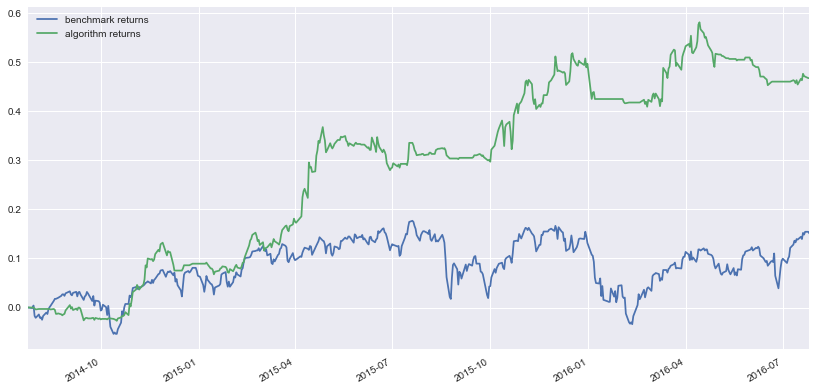

In [59]:
"""
    持有一天卖出策略AbuFactorSellNDay只对应AbuFactorBuyWD生效
    双均线卖出死叉只对应买入动态双均线金叉生效
    海龟21天周期向下卖出只对应海龟42天周期向上买入生效
"""
buy_factors = [
               {'class': AbuFactorBuyWD, 
                'sell_factors': [{'class': AbuFactorSellNDay, 
                                  'sell_n': 1, 'is_sell_today': True}]},
               {'class': AbuDoubleMaBuy, 
                'sell_factors': [{'fast': 5, 'slow': 60, 
                                  'class': AbuDoubleMaSell}]},
               {'xd': 42, 'class': AbuFactorBuyBreak, 
                'sell_factors': [{'xd': 21, 
                                  'class': AbuFactorSellBreak}]}, 
               {'xd': 21, 'class': AbuSDBreak}]

# 基础卖出因子（止盈止损&风险控制&利润保护）对应所有买入因子生效
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0, 'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols)

上面代码的买入，卖出因子策略组织即完成了理想的因子配合方式，如下：

1. 基础卖出因子（止盈止损&风险控制&利润保护）对应所有买入因子生效
2. 海龟21天周期向下卖出只对应海龟42天周期向上买入生效
3. 双均线卖出死叉只对应买入动态双均线金叉生效
4. 持有一天就卖出策略AbuFactorSellNDay只对应短线均值回复买入策略AbuFactorBuyWD

更进一步从下面回测单子中买入因子所对应的卖出因子可看到：

1. AbuDoubleMaSell只对应AbuDoubleMaBuy
2. AbuFactorSellBreak只对应AbuFactorBuyBreak
3. AbuFactorSellNDay只对应AbuFactorBuyWD

如下所示：

In [60]:
abu_result_tuple.orders_pd.groupby('buy_factor')['sell_type_extra'].value_counts()

buy_factor         sell_type_extra                       
AbuDoubleMaBuy     AbuFactorCloseAtrNStop:close_atr_n=1.5    13
                   AbuDoubleMaSell:61                         6
                   AbuFactorAtrNStop:stop_win=3.0             6
                                                              5
                   AbuFactorAtrNStop:stop_loss=1.0            4
                   AbuFactorPreAtrNStop:pre_atr=1.5           4
AbuFactorBuyBreak  AbuFactorCloseAtrNStop:close_atr_n=1.5    17
                   AbuFactorSellBreak:21                     10
                   AbuFactorAtrNStop:stop_win=3.0             5
                   AbuFactorPreAtrNStop:pre_atr=1.5           4
                                                              2
                   AbuFactorAtrNStop:stop_loss=1.0            2
AbuFactorBuyWD     AbuFactorSellNDay:sell_n=1                94
                                                              2
AbuSDBreak         AbuFactorCloseAtrNStop:clos

组合不同特性的买入因子组成良好的买入策略很重要，但是要注意买入因子的组合不是组合的因子越多，优势越大，所有因子的组合、不光是优势的组合，同时也是劣势的组合，关于这方面的示例在之后的教程中会有讲解，请关注公众号中的教程更新。